In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import gensim
import gensim.downloader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard
from time import time
from tqdm import tqdm
maxlen = 100  # Tamaño de entrada de la entrada.


2023-10-26 22:31:08.407425: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 22:31:08.407464: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 22:31:08.408910: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 22:31:08.539913: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_models(model_folder="models"):
    """Carga los archivos de los embeddings entrenados con GENSIM

    Args:
        model_folder (str, optional): Path a la carpeta que contiene todos los modelos. Defaults to "models".

    Returns:
        dict: Diccionario que contiene llave nombre de autor y como valor un diccionario.
        El diccionario interior contiene como llaves el tamaño de los embedings y como valor,
        el modelo word2vec de gensim que corresponde.
    """
    models = [(gensim.models.Word2Vec.load(
        f"{model_folder}/{i}"), i) for i in os.listdir(model_folder)]
    dicts = {}
    for m, mn in models:
        name = "_".join(mn.split("_")[:-1])
        if not name in dicts:
            dicts[name] = {}
        dicts[name][mn.split("_")[-1].split(".")[0]] = m
    return dicts


models = load_models()


In [3]:
def gensim_to_keras_embedding(m_gensim, train_embeddings=False):
    """Convierte un modelo de gensim en una capa de embeddings de keras.
    Tomado de: https://github.com/piskvorky/gensim/wiki/Using-Gensim-Embeddings-with-Keras-and-Tensorflow

    Args:
        m_gensim (word2vec model): modelo de gensim
        train_embeddings (bool, optional): Si entrenar o no los embedings en keras. Defaults to False.

    Returns:
        keras.layers.Embedding: Capa de embedding con los pesos adecuados
    """
    keyed_vectors = m_gensim.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array
    # which row in `weights` corresponds to which word?
    index_to_key = keyed_vectors.index_to_key

    layer = layers.Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        input_length=maxlen,
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer


def gensim_to_keras_embedding_kv(keyed_vectors, train_embeddings=False):
    """Convierte un modelo de gensim en una capa de embeddings de keras.
    Adaptado de: https://github.com/piskvorky/gensim/wiki/Using-Gensim-Embeddings-with-Keras-and-Tensorflow
    Esta funcion sirve para cargar los modelos preentrenados de glove.

    Args:
        m_gensim (gensim.keyedVectors): Vector del embedding de gensim
        train_embeddings (bool, optional): Si entrenar o no los embedings en keras. Defaults to False.

    Returns:
        keras.layers.Embedding: Capa de embedding con los pesos adecuados
    """
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array
    # which row in `weights` corresponds to which word?
    index_to_key = keyed_vectors.index_to_key

    layer = layers.Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        input_length=maxlen,
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer


def processing_text(texto):
    """Preprocesamiento de texto

    1. Pasa a minusculas
    2. Elimina signos de puntuacion
    3. Elimina caracteres especiales
    4. Elimina numeros
    5. Divide en palabras
    Args:
        texto (str): Texto de entrada

    Returns:
        list: Lista de tokens (palabras)
    """
    texto = texto.lower()
    processed_feature = re.sub(r'\W', ' ', str(texto))
    processed_feature = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'[0-9]+', ' ', processed_feature)
    processed_feature = re.sub(' +', ' ', processed_feature)
    return processed_feature.strip().split(" ")


def create_model(kind="150", type_model="conv"):
    """Crea un modelo de keras y un tokenizador de keras basado en un embedding y un tipo de modelo

    Args:
        kind (str, optional): Modelo de embedding a usar. Defaults to "150".
            El kind puede ser uno de los siguientes:
                -   "20" Embeddings entrenados con tamaño 20
                -   "50" Embeddings entrenados con tamaño 50
                -   "150" Embeddings entrenados con tamaño 150
                -   "200" Embeddings entrenados con tamaño 200
                -   "250" Embeddings entrenados con tamaño 500
                -   "gensim_XXXXX" Donde XXXXX es alguno de los modelos preentrenados de gensim.
        type_model (str, optional): Tipo de arquitectura a usar. Defaults to "conv".
            El type_model puede ser uno de los siguientes:
                -   "conv" Para tener una capa convolucional
                -   "pooling" Para tener una capa de global max pooling
                -   "flatten" Para tener una capa de flatten

    Returns:
        keras.model, keras.tokenizer: El modelo de keras y el tokenizador necesario para procesar el texto
    """
    inp = layers.Input(maxlen)
    if "gensim" in kind:
        gmodel = gensim.downloader.load(kind.split("_")[1])
        merged = gensim_to_keras_embedding_kv(gmodel)(inp)
        vocabulary = gmodel.key_to_index
    else:
        carlos_emb = gensim_to_keras_embedding(models["CARLITOS"][kind])(inp)
        julio_emb = gensim_to_keras_embedding(models["DON_JULIO"][kind])(inp)
        pozo_emb = gensim_to_keras_embedding(models["MR_POZO"][kind])(inp)
        merged = layers.Concatenate()([carlos_emb, julio_emb, pozo_emb])
        vocabulary = models["CARLITOS"][kind].wv.key_to_index
    tk = Tokenizer(num_words=len(vocabulary))
    tk.word_index = vocabulary
    if type_model == "flatten":
        x = layers.Flatten()(merged)
    elif type_model == "pooling":
        x = layers.GlobalMaxPool1D()(merged)
    else:
        x = keras.layers.Conv1D(32, 3, activation='sigmoid')(merged)
        x = layers.GlobalMaxPool1D()(x)
    x = layers.Dense(maxlen, activation='sigmoid')(x)
    x = layers.Dense(100, activation='sigmoid')(x)
    x = layers.Dense(50, activation='sigmoid')(x)
    x = layers.Dense(30, activation='sigmoid')(x)
    x = layers.Dense(10, activation='sigmoid')(x)
    out = layers.Dense(3, activation='softmax')(x)
    model = keras.Model(inputs=[inp], outputs=[out])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model, tk


def plot_history(history):
    """Crea una gráfica del loss y el accuracy de entrenamiento y validación
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


def load_dataset(folders=["CARLITOS", "DON_JULIO", "MR_POZO"], split=0.2):
    """Carga el dataset completo a partir de las carpetas de los libros.

    El procesamiento del dataset se realiza en dos partes.
    1. Leer el libro como una sola cadena de texto
    2. Separar el texto en segmentos de igual tamaño (maxlen)

    Este procedimiento se realiza para cada libro y para todos los autores

    Posteriormente se realiza un split del dataset con un 20% de repartición

    Args:
        folders (list, optional): Lista de las carpetas a extraer los libros. Defaults to ["CARLITOS", "DON_JULIO", "MR_POZO"].
        split (float, optional): Split del dataset de entrenamiento y validacion. Defaults to 0.2.

    Returns:
        sentences_train: Lista de tokens para entrenamiento
        sentences_test: Lista de tokens para validacion
        y_train: Lista de labels para entrenamiento
        y_test: Lista de labels para validacion
        X: Lista de oraciones original
        Y: Lista de labels original
    """
    X = []
    Y = []
    for folder in folders:
        files = [f"{folder}/{i}" for i in os.listdir(folder)]
        for f in tqdm(files):
            # lines = [i.strip().replace("\n"," ") for i in open(f, encoding="utf-8").read().split("\n\n")]
            words = processing_text(
                open(f, encoding="utf-8").read().replace("\n", " "))
            lines = [words[i:i+maxlen] for i in range(0, len(words), maxlen)]
            X.extend(lines)
            Y.extend([folder]*len(lines))
    encoder = OneHotEncoder(sparse_output=False)
    Y = np.array(Y)
    Y = Y.reshape([len(Y), 1])
    Y = encoder.fit_transform(Y)
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        X, Y, test_size=split, random_state=42)
    return sentences_train, sentences_test, y_train, y_test, X, Y


In [4]:
sentences_train, sentences_test, y_train, y_test, X, Y = load_dataset()
unicos = np.unique(Y, axis=0)
n = len(Y)
print("Cantidad total de datos", n)
for u in unicos:
    m = np.sum(np.all(Y == u, axis=1)*1)
    p = m/n
    print("Clase", u, "cantidad", m, p*100, "%")


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 21.68it/s]

Cantidad total de datos 9839
Clase [0. 0. 1.] cantidad 1391 14.137615611342616 %
Clase [0. 1. 0.] cantidad 2921 29.687976420367924 %
Clase [1. 0. 0.] cantidad 5527 56.174407968289465 %


In [ ]:

def run_model(embeddings_model="20", name="", folder="conv", type_model="conv"):
    """_summary_

    Args:
        embeddings_model (str, optional): _description_. Defaults to "20".
        name (str, optional): _description_. Defaults to "".
        folder (str, optional): _description_. Defaults to "conv".
        type_model (str, optional): _description_. Defaults to "conv".

    Returns:
        _type_: _description_
    """
    model, tk = create_model(embeddings_model, type_model)
    tensorboard = TensorBoard(
        log_dir=f'./logs_{folder}/{embeddings_model}{name}')
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=5)
    checkpoint_filepath = f'./compiled_{folder}/{embeddings_model}{name}.tf'
    try:
        os.makedirs(checkpoint_filepath)
    except:
        pass
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        save_format="tf")

    X_train = tk.texts_to_sequences(sentences_train)
    X_test = tk.texts_to_sequences(sentences_test)
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
    history = model.fit(X_train, y_train,
                        epochs=100,
                        validation_data=(X_test, y_test),
                        batch_size=5,
                        verbose=True,
                        callbacks=[model_checkpoint_callback, tensorboard, early_stop])
    loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    plot_history(history)
    return model


Para entrenar un modelo, se usa la funcion `run_model`. Se le pasa por parametro el tipo de modelo (str). Se puede optar por las siguientes alternativas:

-   "20" Embeddings entrenados con tamaño 20
-   "50" Embeddings entrenados con tamaño 50
-   "150" Embeddings entrenados con tamaño 150
-   "200" Embeddings entrenados con tamaño 200
-   "250" Embeddings entrenados con tamaño 500
-   "gensim_XXXXX" Donde XXXXX es alguno de los modelos preentrenados de gensim.

Adicionalmente se le puede agregar un nombre adicional al modelo y una carpeta donde se guarden los checkpoints de entrenamiento.


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
1049/1050 [============================>.] - ETA: 0s - loss: 0.7013 - accuracy: 0.7005INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20conv_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20conv_150_words.tf\assets


1050/1050 [==============================] - 13s 10ms/step - loss: 0.7017 - accuracy: 0.7003 - val_loss: 0.3503 - val_accuracy: 0.8576
Epoch 2/100
1050/1050 [==============================] - 11s 10ms/step - loss: 0.3375 - accuracy: 0.8464 - val_loss: 0.3455 - val_accuracy: 0.8530
Epoch 3/100
1050/1050 [==============================] - 8s 7ms/step - loss: 0.3282 - accuracy: 0.8464 - val_loss: 0.3320 - val_accuracy: 0.8576
Epoch 4/100
1047/1050 [============================>.] - ETA: 0s - loss: 0.3285 - accuracy: 0.8458INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20conv_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20conv_150_words.tf\assets


1050/1050 [==============================] - 9s 8ms/step - loss: 0.3293 - accuracy: 0.8453 - val_loss: 0.3201 - val_accuracy: 0.8583
Epoch 5/100
1048/1050 [============================>.] - ETA: 0s - loss: 0.1885 - accuracy: 0.9399INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20conv_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20conv_150_words.tf\assets


1050/1050 [==============================] - 9s 9ms/step - loss: 0.1883 - accuracy: 0.9400 - val_loss: 0.1208 - val_accuracy: 0.9772
Epoch 6/100
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0855 - accuracy: 0.9806 - val_loss: 0.0886 - val_accuracy: 0.9733
Epoch 7/100
1050/1050 [==============================] - 8s 7ms/step - loss: 0.0611 - accuracy: 0.9817 - val_loss: 0.0689 - val_accuracy: 0.9733
Epoch 8/100
1050/1050 [==============================] - 7s 7ms/step - loss: 0.0460 - accuracy: 0.9819 - val_loss: 0.0621 - val_accuracy: 0.9703
Epoch 9/100
1050/1050 [==============================] - 9s 9ms/step - loss: 0.0418 - accuracy: 0.9813 - val_loss: 0.0559 - val_accuracy: 0.9741
Epoch 10/100
1050/1050 [==============================] - 8s 8ms/step - loss: 0.0388 - accuracy: 0.9815 - val_loss: 0.0466 - val_accuracy: 0.9726
Training Accuracy: 0.9834
Testing Accuracy:  0.9726
You must install pydot (`pip install pydot`) and install graphviz (see instructions at ht

INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20pooling_150_words.tf\assets


1050/1050 [==============================] - 10s 7ms/step - loss: 0.9421 - accuracy: 0.5743 - val_loss: 0.6274 - val_accuracy: 0.7997
Epoch 2/100
1036/1050 [============================>.] - ETA: 0s - loss: 0.4588 - accuracy: 0.8363INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20pooling_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20pooling_150_words.tf\assets


1050/1050 [==============================] - 8s 7ms/step - loss: 0.4561 - accuracy: 0.8377 - val_loss: 0.2886 - val_accuracy: 0.9276
Epoch 3/100
1046/1050 [============================>.] - ETA: 0s - loss: 0.2160 - accuracy: 0.9459INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20pooling_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20pooling_150_words.tf\assets


1050/1050 [==============================] - 6s 6ms/step - loss: 0.2169 - accuracy: 0.9455 - val_loss: 0.1835 - val_accuracy: 0.9558
Epoch 4/100
1042/1050 [============================>.] - ETA: 0s - loss: 0.1574 - accuracy: 0.9568INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20pooling_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20pooling_150_words.tf\assets


1050/1050 [==============================] - 13s 13ms/step - loss: 0.1586 - accuracy: 0.9566 - val_loss: 0.1643 - val_accuracy: 0.9566
Epoch 5/100
1046/1050 [============================>.] - ETA: 0s - loss: 0.1261 - accuracy: 0.9627INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20pooling_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20pooling_150_words.tf\assets


1050/1050 [==============================] - 8s 8ms/step - loss: 0.1258 - accuracy: 0.9628 - val_loss: 0.1062 - val_accuracy: 0.9634
Epoch 6/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.1238 - accuracy: 0.9598 - val_loss: 0.1067 - val_accuracy: 0.9612
Epoch 7/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.1006 - accuracy: 0.9663 - val_loss: 0.1319 - val_accuracy: 0.9543
Epoch 8/100
1039/1050 [============================>.] - ETA: 0s - loss: 0.1028 - accuracy: 0.9650INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20pooling_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20pooling_150_words.tf\assets


1050/1050 [==============================] - 6s 6ms/step - loss: 0.1030 - accuracy: 0.9651 - val_loss: 0.0882 - val_accuracy: 0.9673
Epoch 9/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0932 - accuracy: 0.9661 - val_loss: 0.1334 - val_accuracy: 0.9505
Epoch 10/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0916 - accuracy: 0.9667 - val_loss: 0.1303 - val_accuracy: 0.9558
Epoch 11/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0992 - accuracy: 0.9653 - val_loss: 0.0998 - val_accuracy: 0.9612
Epoch 12/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0915 - accuracy: 0.9649 - val_loss: 0.1138 - val_accuracy: 0.9604
Epoch 13/100
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0882 - accuracy: 0.9670 - val_loss: 0.1409 - val_accuracy: 0.9520
Training Accuracy: 0.9594
Testing Accuracy:  0.9520
You must install pydot (`pip install pydot`) and install graphviz (see instructions at

INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


1050/1050 [==============================] - 41s 37ms/step - loss: 0.8729 - accuracy: 0.6136 - val_loss: 0.8584 - val_accuracy: 0.7014
Epoch 2/100
1050/1050 [==============================] - ETA: 0s - loss: 0.6549 - accuracy: 0.7393INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


1050/1050 [==============================] - 39s 37ms/step - loss: 0.6549 - accuracy: 0.7393 - val_loss: 0.6168 - val_accuracy: 0.7609
Epoch 3/100
1050/1050 [==============================] - ETA: 0s - loss: 0.5543 - accuracy: 0.7818INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


1050/1050 [==============================] - 38s 36ms/step - loss: 0.5543 - accuracy: 0.7818 - val_loss: 0.5892 - val_accuracy: 0.7746
Epoch 4/100
1049/1050 [============================>.] - ETA: 0s - loss: 0.4980 - accuracy: 0.8002INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


1050/1050 [==============================] - 40s 39ms/step - loss: 0.4978 - accuracy: 0.8003 - val_loss: 0.5508 - val_accuracy: 0.8020
Epoch 5/100
1050/1050 [==============================] - 38s 36ms/step - loss: 0.4609 - accuracy: 0.8129 - val_loss: 0.5509 - val_accuracy: 0.7982
Epoch 6/100
1049/1050 [============================>.] - ETA: 0s - loss: 0.4048 - accuracy: 0.8360INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


1050/1050 [==============================] - 39s 37ms/step - loss: 0.4046 - accuracy: 0.8361 - val_loss: 0.6340 - val_accuracy: 0.8256
Epoch 7/100
1050/1050 [==============================] - 38s 37ms/step - loss: 0.3699 - accuracy: 0.8666 - val_loss: 0.5335 - val_accuracy: 0.8111
Epoch 8/100
1049/1050 [============================>.] - ETA: 0s - loss: 0.3487 - accuracy: 0.8774INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


1050/1050 [==============================] - 39s 37ms/step - loss: 0.3488 - accuracy: 0.8773 - val_loss: 0.4799 - val_accuracy: 0.8454
Epoch 9/100
1050/1050 [==============================] - 37s 35ms/step - loss: 0.3083 - accuracy: 0.9028 - val_loss: 0.9753 - val_accuracy: 0.6002
Epoch 10/100
1050/1050 [==============================] - 37s 35ms/step - loss: 0.2715 - accuracy: 0.9186 - val_loss: 0.6014 - val_accuracy: 0.7814
Epoch 11/100
1050/1050 [==============================] - 37s 35ms/step - loss: 0.2593 - accuracy: 0.9245 - val_loss: 0.6027 - val_accuracy: 0.7700
Epoch 12/100
1049/1050 [============================>.] - ETA: 0s - loss: 0.2442 - accuracy: 0.9300INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


1050/1050 [==============================] - 39s 37ms/step - loss: 0.2441 - accuracy: 0.9301 - val_loss: 0.5973 - val_accuracy: 0.8484
Epoch 13/100
1050/1050 [==============================] - 33s 32ms/step - loss: 0.2217 - accuracy: 0.9405 - val_loss: 0.5359 - val_accuracy: 0.8462
Epoch 14/100
1050/1050 [==============================] - 34s 32ms/step - loss: 0.2134 - accuracy: 0.9426 - val_loss: 0.6736 - val_accuracy: 0.8431
Epoch 15/100
1050/1050 [==============================] - 33s 32ms/step - loss: 0.2159 - accuracy: 0.9425 - val_loss: 0.5916 - val_accuracy: 0.8484
Epoch 16/100
1050/1050 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.9474INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


1050/1050 [==============================] - 35s 34ms/step - loss: 0.2047 - accuracy: 0.9474 - val_loss: 0.6437 - val_accuracy: 0.8545
Epoch 17/100
1050/1050 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9466INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


1050/1050 [==============================] - 35s 33ms/step - loss: 0.2024 - accuracy: 0.9466 - val_loss: 0.5868 - val_accuracy: 0.8660
Epoch 18/100
1049/1050 [============================>.] - ETA: 0s - loss: 0.1996 - accuracy: 0.9476INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


INFO:tensorflow:Assets written to: ./compiled_prueba_modelos\20flatten_150_words.tf\assets


1050/1050 [==============================] - 36s 34ms/step - loss: 0.1994 - accuracy: 0.9476 - val_loss: 0.5387 - val_accuracy: 0.8728
Epoch 19/100
1050/1050 [==============================] - 34s 32ms/step - loss: 0.1759 - accuracy: 0.9577 - val_loss: 0.6377 - val_accuracy: 0.8317
Epoch 20/100
1050/1050 [==============================] - 34s 32ms/step - loss: 0.1954 - accuracy: 0.9514 - val_loss: 0.6128 - val_accuracy: 0.8477
Epoch 21/100
1050/1050 [==============================] - 34s 32ms/step - loss: 0.2031 - accuracy: 0.9459 - val_loss: 0.5421 - val_accuracy: 0.8637
Epoch 22/100
1050/1050 [==============================] - 34s 32ms/step - loss: 0.1712 - accuracy: 0.9575 - val_loss: 0.4933 - val_accuracy: 0.8652
Epoch 23/100
1050/1050 [==============================] - 35s 34ms/step - loss: 0.2006 - accuracy: 0.9436 - val_loss: 0.5595 - val_accuracy: 0.7517
Training Accuracy: 0.8939
Testing Accuracy:  0.7517


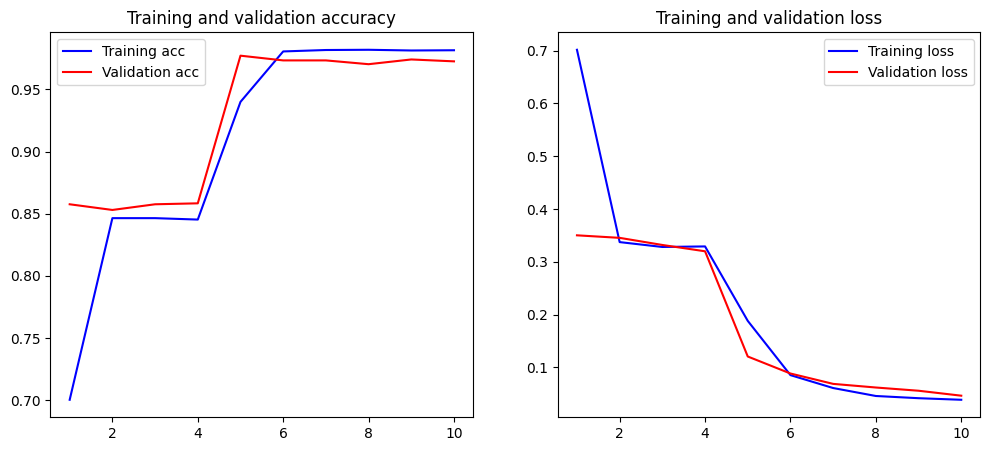

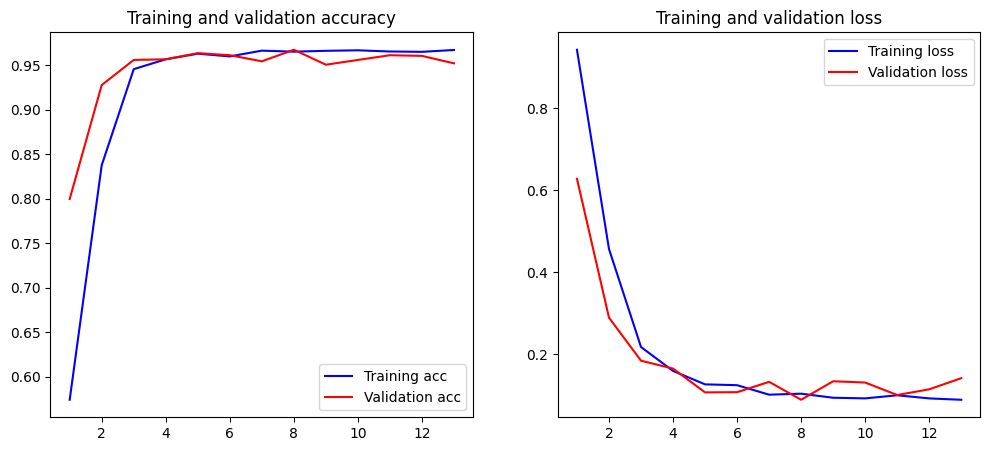

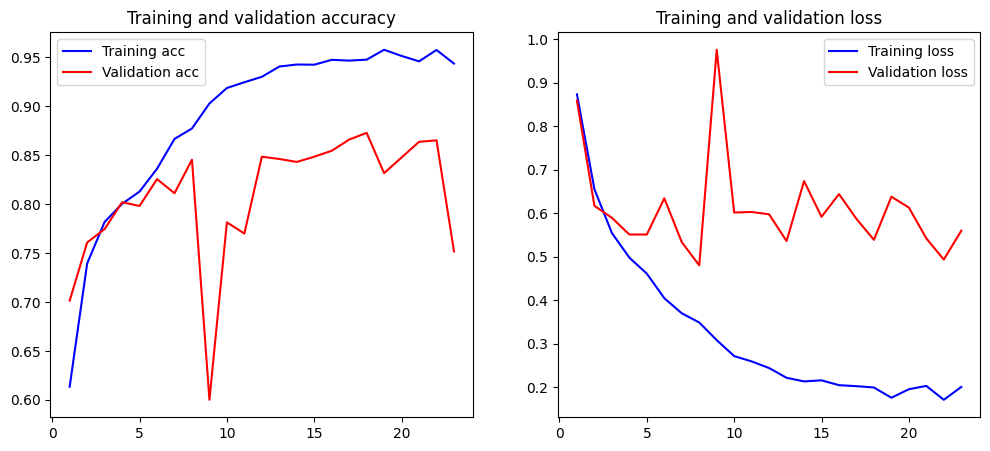

In [6]:
run_model("20", f"conv_{maxlen}_words",
          folder="prueba_modelos", type_model="conv")
run_model("20", f"pooling_{maxlen}_words",
          folder="prueba_modelos", type_model="pooling")
run_model("20", f"flatten_{maxlen}_words",
          folder="prueba_modelos", type_model="flatten")


Epoch 1/100
3148/3148 [==============================] - ETA: 0s - loss: 0.7203 - accuracy: 0.6937INFO:tensorflow:Assets written to: ./compiled_entrega/20_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/20_50_words.tf/assets


3148/3148 [==============================] - 21s 6ms/step - loss: 0.7203 - accuracy: 0.6937 - val_loss: 0.2256 - val_accuracy: 0.9291
Epoch 2/100
3144/3148 [============================>.] - ETA: 0s - loss: 0.1642 - accuracy: 0.9382INFO:tensorflow:Assets written to: ./compiled_entrega/20_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/20_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.1642 - accuracy: 0.9382 - val_loss: 0.1277 - val_accuracy: 0.9469
Epoch 3/100
3140/3148 [============================>.] - ETA: 0s - loss: 0.1018 - accuracy: 0.9585INFO:tensorflow:Assets written to: ./compiled_entrega/20_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/20_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.1018 - accuracy: 0.9585 - val_loss: 0.1041 - val_accuracy: 0.9596
Epoch 4/100
3147/3148 [============================>.] - ETA: 0s - loss: 0.0803 - accuracy: 0.9651INFO:tensorflow:Assets written to: ./compiled_entrega/20_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/20_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.0803 - accuracy: 0.9651 - val_loss: 0.0852 - val_accuracy: 0.9642
Epoch 5/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0661 - accuracy: 0.9720 - val_loss: 0.0928 - val_accuracy: 0.9621
Epoch 6/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0600 - accuracy: 0.9733 - val_loss: 0.0843 - val_accuracy: 0.9626
Epoch 7/100
3142/3148 [============================>.] - ETA: 0s - loss: 0.0535 - accuracy: 0.9749INFO:tensorflow:Assets written to: ./compiled_entrega/20_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/20_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.0535 - accuracy: 0.9750 - val_loss: 0.0903 - val_accuracy: 0.9644
Epoch 8/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0497 - accuracy: 0.9763 - val_loss: 0.1077 - val_accuracy: 0.9614
Epoch 9/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0468 - accuracy: 0.9783 - val_loss: 0.1271 - val_accuracy: 0.9581
Epoch 10/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0417 - accuracy: 0.9797 - val_loss: 0.1130 - val_accuracy: 0.9632
Epoch 11/100
3148/3148 [==============================] - 20s 6ms/step - loss: 0.0413 - accuracy: 0.9801 - val_loss: 0.1341 - val_accuracy: 0.9614
Epoch 12/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0441 - accuracy: 0.9797 - val_loss: 0.1011 - val_accuracy: 0.9642
Training Accuracy: 0.9827
Testing Accuracy:  0.9642
Epoch 1/100
3148/3148 [==============================] - ETA: 0s - loss: 0.4186 -

INFO:tensorflow:Assets written to: ./compiled_entrega/50_50_words.tf/assets


3148/3148 [==============================] - 21s 6ms/step - loss: 0.4186 - accuracy: 0.8356 - val_loss: 0.1943 - val_accuracy: 0.9304
Epoch 2/100
3140/3148 [============================>.] - ETA: 0s - loss: 0.1624 - accuracy: 0.9468INFO:tensorflow:Assets written to: ./compiled_entrega/50_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/50_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.1625 - accuracy: 0.9467 - val_loss: 0.1526 - val_accuracy: 0.9507
Epoch 3/100
3141/3148 [============================>.] - ETA: 0s - loss: 0.1004 - accuracy: 0.9661INFO:tensorflow:Assets written to: ./compiled_entrega/50_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/50_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.1003 - accuracy: 0.9661 - val_loss: 0.0924 - val_accuracy: 0.9657
Epoch 4/100
3148/3148 [==============================] - 20s 6ms/step - loss: 0.0640 - accuracy: 0.9735 - val_loss: 0.0955 - val_accuracy: 0.9619
Epoch 5/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0521 - accuracy: 0.9761 - val_loss: 0.1067 - val_accuracy: 0.9611
Epoch 6/100
3148/3148 [==============================] - 20s 6ms/step - loss: 0.0501 - accuracy: 0.9767 - val_loss: 0.1003 - val_accuracy: 0.9609
Epoch 7/100
3148/3148 [==============================] - 20s 6ms/step - loss: 0.0426 - accuracy: 0.9804 - val_loss: 0.1041 - val_accuracy: 0.9598
Epoch 8/100
3148/3148 [==============================] - 20s 6ms/step - loss: 0.0428 - accuracy: 0.9797 - val_loss: 0.2090 - val_accuracy: 0.9517
Training Accuracy: 0.9724
Testing Accuracy:  0.9517
Epoch 1/100
3148/3148 [==============================] - ETA: 0s - loss: 0.4901 - ac

INFO:tensorflow:Assets written to: ./compiled_entrega/150_50_words.tf/assets


3148/3148 [==============================] - 21s 6ms/step - loss: 0.4901 - accuracy: 0.7937 - val_loss: 0.2153 - val_accuracy: 0.9240
Epoch 2/100
3143/3148 [============================>.] - ETA: 0s - loss: 0.1528 - accuracy: 0.9454INFO:tensorflow:Assets written to: ./compiled_entrega/150_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/150_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.1528 - accuracy: 0.9454 - val_loss: 0.1311 - val_accuracy: 0.9555
Epoch 3/100
3148/3148 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9691INFO:tensorflow:Assets written to: ./compiled_entrega/150_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/150_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.0816 - accuracy: 0.9691 - val_loss: 0.1083 - val_accuracy: 0.9573
Epoch 4/100
3148/3148 [==============================] - 20s 6ms/step - loss: 0.0625 - accuracy: 0.9753 - val_loss: 0.1562 - val_accuracy: 0.9510
Epoch 5/100
3148/3148 [==============================] - 20s 6ms/step - loss: 0.0546 - accuracy: 0.9760 - val_loss: 0.1374 - val_accuracy: 0.9515
Epoch 6/100
3142/3148 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9768INFO:tensorflow:Assets written to: ./compiled_entrega/150_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/150_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.0488 - accuracy: 0.9769 - val_loss: 0.1146 - val_accuracy: 0.9614
Epoch 7/100
3148/3148 [==============================] - 20s 6ms/step - loss: 0.0422 - accuracy: 0.9792 - val_loss: 0.1303 - val_accuracy: 0.9609
Epoch 8/100
3148/3148 [==============================] - 20s 6ms/step - loss: 0.0418 - accuracy: 0.9797 - val_loss: 0.1464 - val_accuracy: 0.9601
Epoch 9/100
3148/3148 [==============================] - 20s 6ms/step - loss: 0.0427 - accuracy: 0.9802 - val_loss: 0.1248 - val_accuracy: 0.9606
Epoch 10/100
3148/3148 [==============================] - 20s 6ms/step - loss: 0.0404 - accuracy: 0.9804 - val_loss: 0.1435 - val_accuracy: 0.9586
Epoch 11/100
3148/3148 [==============================] - 20s 6ms/step - loss: 0.0358 - accuracy: 0.9813 - val_loss: 0.1426 - val_accuracy: 0.9571
Training Accuracy: 0.9816
Testing Accuracy:  0.9571
Epoch 1/100
3148/3148 [==============================] - ETA: 0s - loss: 0.3681 - 

INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


3148/3148 [==============================] - 21s 6ms/step - loss: 0.3681 - accuracy: 0.8591 - val_loss: 0.2396 - val_accuracy: 0.9291
Epoch 2/100
3147/3148 [============================>.] - ETA: 0s - loss: 0.1371 - accuracy: 0.9574INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.1372 - accuracy: 0.9573 - val_loss: 0.1447 - val_accuracy: 0.9555
Epoch 3/100
3140/3148 [============================>.] - ETA: 0s - loss: 0.0880 - accuracy: 0.9725INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.0879 - accuracy: 0.9726 - val_loss: 0.1072 - val_accuracy: 0.9616
Epoch 4/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0671 - accuracy: 0.9746 - val_loss: 0.1095 - val_accuracy: 0.9591
Epoch 5/100
3140/3148 [============================>.] - ETA: 0s - loss: 0.0551 - accuracy: 0.9771INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.0549 - accuracy: 0.9772 - val_loss: 0.1052 - val_accuracy: 0.9621
Epoch 6/100
3147/3148 [============================>.] - ETA: 0s - loss: 0.0492 - accuracy: 0.9779INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.0493 - accuracy: 0.9779 - val_loss: 0.1024 - val_accuracy: 0.9634
Epoch 7/100
3148/3148 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9794INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.0445 - accuracy: 0.9794 - val_loss: 0.1093 - val_accuracy: 0.9639
Epoch 8/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0434 - accuracy: 0.9788 - val_loss: 0.1201 - val_accuracy: 0.9609
Epoch 9/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0404 - accuracy: 0.9802 - val_loss: 0.1343 - val_accuracy: 0.9588
Epoch 10/100
3142/3148 [============================>.] - ETA: 0s - loss: 0.0415 - accuracy: 0.9803INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.0415 - accuracy: 0.9804 - val_loss: 0.1120 - val_accuracy: 0.9652
Epoch 11/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0371 - accuracy: 0.9807 - val_loss: 0.1472 - val_accuracy: 0.9593
Epoch 12/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0381 - accuracy: 0.9803 - val_loss: 0.1223 - val_accuracy: 0.9632
Epoch 13/100
3141/3148 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9802INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.0385 - accuracy: 0.9802 - val_loss: 0.1223 - val_accuracy: 0.9657
Epoch 14/100
3147/3148 [============================>.] - ETA: 0s - loss: 0.0364 - accuracy: 0.9804INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/200_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.0364 - accuracy: 0.9804 - val_loss: 0.1313 - val_accuracy: 0.9667
Epoch 15/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0365 - accuracy: 0.9802 - val_loss: 0.1730 - val_accuracy: 0.9568
Epoch 16/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0375 - accuracy: 0.9813 - val_loss: 0.1169 - val_accuracy: 0.9654
Epoch 17/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0357 - accuracy: 0.9806 - val_loss: 0.1276 - val_accuracy: 0.9647
Epoch 18/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0362 - accuracy: 0.9806 - val_loss: 0.1414 - val_accuracy: 0.9611
Epoch 19/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.0337 - accuracy: 0.9828 - val_loss: 0.1290 - val_accuracy: 0.9616
Training Accuracy: 0.9828
Testing Accuracy:  0.9616
Epoch 1/100
3148/3148 [==============================] - ETA: 0s - loss: 0.4127

INFO:tensorflow:Assets written to: ./compiled_entrega/250_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.4127 - accuracy: 0.8380 - val_loss: 0.1813 - val_accuracy: 0.9370
Epoch 2/100
3145/3148 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9643INFO:tensorflow:Assets written to: ./compiled_entrega/250_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/250_50_words.tf/assets


3148/3148 [==============================] - 19s 6ms/step - loss: 0.1220 - accuracy: 0.9644 - val_loss: 0.1228 - val_accuracy: 0.9601
Epoch 3/100
3148/3148 [==============================] - 18s 6ms/step - loss: 0.0723 - accuracy: 0.9729 - val_loss: 0.1073 - val_accuracy: 0.9571
Epoch 4/100
3148/3148 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9762INFO:tensorflow:Assets written to: ./compiled_entrega/250_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/250_50_words.tf/assets


3148/3148 [==============================] - 19s 6ms/step - loss: 0.0571 - accuracy: 0.9762 - val_loss: 0.0897 - val_accuracy: 0.9637
Epoch 5/100
3142/3148 [============================>.] - ETA: 0s - loss: 0.0460 - accuracy: 0.9792INFO:tensorflow:Assets written to: ./compiled_entrega/250_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/250_50_words.tf/assets


3148/3148 [==============================] - 19s 6ms/step - loss: 0.0462 - accuracy: 0.9792 - val_loss: 0.0941 - val_accuracy: 0.9665
Epoch 6/100
3140/3148 [============================>.] - ETA: 0s - loss: 0.0436 - accuracy: 0.9791INFO:tensorflow:Assets written to: ./compiled_entrega/250_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/250_50_words.tf/assets


3148/3148 [==============================] - 19s 6ms/step - loss: 0.0436 - accuracy: 0.9791 - val_loss: 0.0940 - val_accuracy: 0.9670
Epoch 7/100
3148/3148 [==============================] - 18s 6ms/step - loss: 0.0402 - accuracy: 0.9813 - val_loss: 0.1253 - val_accuracy: 0.9619
Epoch 8/100
3148/3148 [==============================] - 18s 6ms/step - loss: 0.0387 - accuracy: 0.9806 - val_loss: 0.1860 - val_accuracy: 0.9558
Epoch 9/100
3148/3148 [==============================] - 18s 6ms/step - loss: 0.0387 - accuracy: 0.9814 - val_loss: 0.1090 - val_accuracy: 0.9637
Epoch 10/100
3148/3148 [==============================] - 18s 6ms/step - loss: 0.0389 - accuracy: 0.9798 - val_loss: 0.1579 - val_accuracy: 0.9614
Epoch 11/100
3148/3148 [==============================] - 18s 6ms/step - loss: 0.0366 - accuracy: 0.9807 - val_loss: 0.1856 - val_accuracy: 0.9578
Training Accuracy: 0.9795
Testing Accuracy:  0.9578
Epoch 1/100
3148/3148 [==============================] - ETA: 0s - loss: 0.8751 - 

INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


3148/3148 [==============================] - 21s 6ms/step - loss: 0.8751 - accuracy: 0.6214 - val_loss: 0.7115 - val_accuracy: 0.7311
Epoch 2/100
3147/3148 [============================>.] - ETA: 0s - loss: 0.6578 - accuracy: 0.7384INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.6578 - accuracy: 0.7384 - val_loss: 0.6192 - val_accuracy: 0.7565
Epoch 3/100
3142/3148 [============================>.] - ETA: 0s - loss: 0.5891 - accuracy: 0.7617INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.5893 - accuracy: 0.7617 - val_loss: 0.5806 - val_accuracy: 0.7662
Epoch 4/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.5487 - accuracy: 0.7726 - val_loss: 0.5763 - val_accuracy: 0.7626
Epoch 5/100
3144/3148 [============================>.] - ETA: 0s - loss: 0.5194 - accuracy: 0.7810INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.5192 - accuracy: 0.7810 - val_loss: 0.5698 - val_accuracy: 0.7685
Epoch 6/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.4993 - accuracy: 0.7903 - val_loss: 0.7044 - val_accuracy: 0.7113
Epoch 7/100
3148/3148 [==============================] - ETA: 0s - loss: 0.4824 - accuracy: 0.7966INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.4824 - accuracy: 0.7966 - val_loss: 0.5481 - val_accuracy: 0.7703
Epoch 8/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.4700 - accuracy: 0.8035 - val_loss: 0.5562 - val_accuracy: 0.7604
Epoch 9/100
3146/3148 [============================>.] - ETA: 0s - loss: 0.4555 - accuracy: 0.8078INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.4555 - accuracy: 0.8078 - val_loss: 0.5617 - val_accuracy: 0.7746
Epoch 10/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.4451 - accuracy: 0.8138 - val_loss: 0.5635 - val_accuracy: 0.7705
Epoch 11/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.4335 - accuracy: 0.8200 - val_loss: 0.5605 - val_accuracy: 0.7705
Epoch 12/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.4252 - accuracy: 0.8231 - val_loss: 0.5584 - val_accuracy: 0.7743
Epoch 13/100
3143/3148 [============================>.] - ETA: 0s - loss: 0.4166 - accuracy: 0.8254INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


3148/3148 [==============================] - 19s 6ms/step - loss: 0.4165 - accuracy: 0.8254 - val_loss: 0.5613 - val_accuracy: 0.7787
Epoch 14/100
3139/3148 [============================>.] - ETA: 0s - loss: 0.4089 - accuracy: 0.8331INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.4088 - accuracy: 0.8331 - val_loss: 0.5518 - val_accuracy: 0.7832
Epoch 15/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3957 - accuracy: 0.8400 - val_loss: 0.5811 - val_accuracy: 0.7695
Epoch 16/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3886 - accuracy: 0.8419 - val_loss: 0.5420 - val_accuracy: 0.7789
Epoch 17/100
3148/3148 [==============================] - ETA: 0s - loss: 0.3830 - accuracy: 0.8436INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.3830 - accuracy: 0.8436 - val_loss: 0.5310 - val_accuracy: 0.7845
Epoch 18/100
3140/3148 [============================>.] - ETA: 0s - loss: 0.3762 - accuracy: 0.8504INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.3767 - accuracy: 0.8501 - val_loss: 0.5336 - val_accuracy: 0.7944
Epoch 19/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3657 - accuracy: 0.8548 - val_loss: 0.5470 - val_accuracy: 0.7911
Epoch 20/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3609 - accuracy: 0.8552 - val_loss: 0.5395 - val_accuracy: 0.7870
Epoch 21/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3547 - accuracy: 0.8584 - val_loss: 0.5672 - val_accuracy: 0.7817
Epoch 22/100
3145/3148 [============================>.] - ETA: 0s - loss: 0.3531 - accuracy: 0.8587INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.3531 - accuracy: 0.8587 - val_loss: 0.5378 - val_accuracy: 0.8005
Epoch 23/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3459 - accuracy: 0.8627 - val_loss: 0.5502 - val_accuracy: 0.7924
Epoch 24/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3396 - accuracy: 0.8660 - val_loss: 0.5365 - val_accuracy: 0.7931
Epoch 25/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3373 - accuracy: 0.8673 - val_loss: 0.5564 - val_accuracy: 0.7967
Epoch 26/100
3139/3148 [============================>.] - ETA: 0s - loss: 0.3348 - accuracy: 0.8661INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.3348 - accuracy: 0.8660 - val_loss: 0.5238 - val_accuracy: 0.8015
Epoch 27/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3307 - accuracy: 0.8706 - val_loss: 0.5507 - val_accuracy: 0.7949
Epoch 28/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3216 - accuracy: 0.8711 - val_loss: 0.5752 - val_accuracy: 0.7995
Epoch 29/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3220 - accuracy: 0.8709 - val_loss: 0.5950 - val_accuracy: 0.7820
Epoch 30/100
3144/3148 [============================>.] - ETA: 0s - loss: 0.3142 - accuracy: 0.8748INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.3144 - accuracy: 0.8747 - val_loss: 0.5676 - val_accuracy: 0.8025
Epoch 31/100
3143/3148 [============================>.] - ETA: 0s - loss: 0.3158 - accuracy: 0.8743INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.3155 - accuracy: 0.8744 - val_loss: 0.5427 - val_accuracy: 0.8043
Epoch 32/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3134 - accuracy: 0.8760 - val_loss: 0.5474 - val_accuracy: 0.8020
Epoch 33/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3092 - accuracy: 0.8767 - val_loss: 0.5772 - val_accuracy: 0.8013
Epoch 34/100
3141/3148 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8767INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-25_50_words.tf/assets


3148/3148 [==============================] - 19s 6ms/step - loss: 0.3075 - accuracy: 0.8766 - val_loss: 0.5738 - val_accuracy: 0.8056
Epoch 35/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3040 - accuracy: 0.8774 - val_loss: 0.5651 - val_accuracy: 0.7982
Epoch 36/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3017 - accuracy: 0.8799 - val_loss: 0.5506 - val_accuracy: 0.7982
Epoch 37/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.2977 - accuracy: 0.8814 - val_loss: 0.5562 - val_accuracy: 0.8030
Epoch 38/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.2944 - accuracy: 0.8821 - val_loss: 0.5728 - val_accuracy: 0.8003
Epoch 39/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.2956 - accuracy: 0.8831 - val_loss: 0.5867 - val_accuracy: 0.8036
Training Accuracy: 0.8837
Testing Accuracy:  0.8036
Epoch 1/100
3145/3148 [============================>.] - ETA: 0s - loss: 0.8018

INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


3148/3148 [==============================] - 21s 6ms/step - loss: 0.8019 - accuracy: 0.6570 - val_loss: 0.6239 - val_accuracy: 0.7555
Epoch 2/100
3139/3148 [============================>.] - ETA: 0s - loss: 0.5567 - accuracy: 0.7741INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.5566 - accuracy: 0.7742 - val_loss: 0.5297 - val_accuracy: 0.7845
Epoch 3/100
3143/3148 [============================>.] - ETA: 0s - loss: 0.4760 - accuracy: 0.7985INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.4763 - accuracy: 0.7985 - val_loss: 0.4975 - val_accuracy: 0.7886
Epoch 4/100
3145/3148 [============================>.] - ETA: 0s - loss: 0.4278 - accuracy: 0.8176INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.4277 - accuracy: 0.8176 - val_loss: 0.4907 - val_accuracy: 0.7982
Epoch 5/100
3144/3148 [============================>.] - ETA: 0s - loss: 0.3964 - accuracy: 0.8307INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.3967 - accuracy: 0.8306 - val_loss: 0.4826 - val_accuracy: 0.7992
Epoch 6/100
3146/3148 [============================>.] - ETA: 0s - loss: 0.3717 - accuracy: 0.8452INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.3717 - accuracy: 0.8451 - val_loss: 0.5135 - val_accuracy: 0.8025
Epoch 7/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3505 - accuracy: 0.8530 - val_loss: 0.5082 - val_accuracy: 0.7954
Epoch 8/100
3147/3148 [============================>.] - ETA: 0s - loss: 0.3346 - accuracy: 0.8627INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.3347 - accuracy: 0.8627 - val_loss: 0.5093 - val_accuracy: 0.8102
Epoch 9/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3167 - accuracy: 0.8726 - val_loss: 0.4967 - val_accuracy: 0.7964
Epoch 10/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3047 - accuracy: 0.8775 - val_loss: 0.5043 - val_accuracy: 0.8043
Epoch 11/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.2909 - accuracy: 0.8859 - val_loss: 0.4921 - val_accuracy: 0.7997
Epoch 12/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.2803 - accuracy: 0.8913 - val_loss: 0.5256 - val_accuracy: 0.8094
Epoch 13/100
3147/3148 [============================>.] - ETA: 0s - loss: 0.2709 - accuracy: 0.8944INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.2709 - accuracy: 0.8944 - val_loss: 0.5465 - val_accuracy: 0.8114
Epoch 14/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.2618 - accuracy: 0.8990 - val_loss: 0.5395 - val_accuracy: 0.7924
Epoch 15/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.2531 - accuracy: 0.9020 - val_loss: 0.5361 - val_accuracy: 0.8102
Epoch 16/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.2450 - accuracy: 0.9081 - val_loss: 0.5212 - val_accuracy: 0.7949
Epoch 17/100
3147/3148 [============================>.] - ETA: 0s - loss: 0.2373 - accuracy: 0.9098INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.2373 - accuracy: 0.9098 - val_loss: 0.5276 - val_accuracy: 0.8140
Epoch 18/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.2273 - accuracy: 0.9150 - val_loss: 0.5940 - val_accuracy: 0.8053
Epoch 19/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.2197 - accuracy: 0.9189 - val_loss: 0.5687 - val_accuracy: 0.8056
Epoch 20/100
3145/3148 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9246INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-50_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.2080 - accuracy: 0.9245 - val_loss: 0.5430 - val_accuracy: 0.8203
Epoch 21/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.2050 - accuracy: 0.9258 - val_loss: 0.5729 - val_accuracy: 0.8117
Epoch 22/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.1990 - accuracy: 0.9271 - val_loss: 0.5829 - val_accuracy: 0.8076
Epoch 23/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.1935 - accuracy: 0.9305 - val_loss: 0.6048 - val_accuracy: 0.8107
Epoch 24/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.1856 - accuracy: 0.9322 - val_loss: 0.6450 - val_accuracy: 0.8175
Epoch 25/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.1826 - accuracy: 0.9351 - val_loss: 0.6495 - val_accuracy: 0.7992
Training Accuracy: 0.9342
Testing Accuracy:  0.7992
Epoch 1/100
3148/3148 [==============================] - ETA: 0s - loss: 0.7326

INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-100_50_words.tf/assets


3148/3148 [==============================] - 21s 6ms/step - loss: 0.7326 - accuracy: 0.6909 - val_loss: 0.5292 - val_accuracy: 0.7934
Epoch 2/100
3143/3148 [============================>.] - ETA: 0s - loss: 0.4654 - accuracy: 0.8020INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-100_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-100_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.4652 - accuracy: 0.8021 - val_loss: 0.4593 - val_accuracy: 0.8112
Epoch 3/100
3143/3148 [============================>.] - ETA: 0s - loss: 0.3829 - accuracy: 0.8371INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-100_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-100_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.3829 - accuracy: 0.8372 - val_loss: 0.4336 - val_accuracy: 0.8168
Epoch 4/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.3287 - accuracy: 0.8647 - val_loss: 0.4492 - val_accuracy: 0.8135
Epoch 5/100
3142/3148 [============================>.] - ETA: 0s - loss: 0.2892 - accuracy: 0.8836INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-100_50_words.tf/assets


INFO:tensorflow:Assets written to: ./compiled_entrega/gensim_glove-twitter-100_50_words.tf/assets


3148/3148 [==============================] - 20s 6ms/step - loss: 0.2896 - accuracy: 0.8836 - val_loss: 0.4723 - val_accuracy: 0.8244
Epoch 6/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.2582 - accuracy: 0.8983 - val_loss: 0.5148 - val_accuracy: 0.8155
Epoch 7/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.2370 - accuracy: 0.9081 - val_loss: 0.5018 - val_accuracy: 0.8191
Epoch 8/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.2151 - accuracy: 0.9196 - val_loss: 0.5173 - val_accuracy: 0.8211
Epoch 9/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.1996 - accuracy: 0.9283 - val_loss: 0.5368 - val_accuracy: 0.8196
Epoch 10/100
3148/3148 [==============================] - 19s 6ms/step - loss: 0.1856 - accuracy: 0.9352 - val_loss: 0.5517 - val_accuracy: 0.8203
Training Accuracy: 0.9582
Testing Accuracy:  0.8203


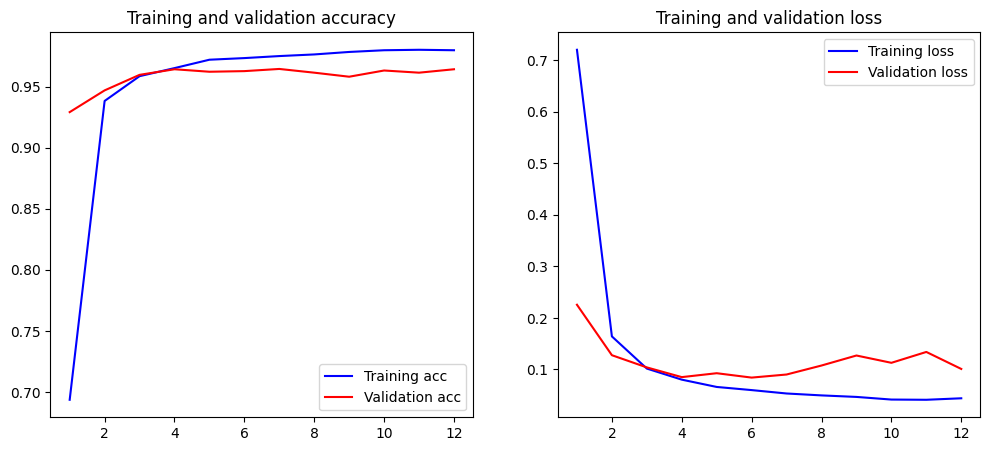

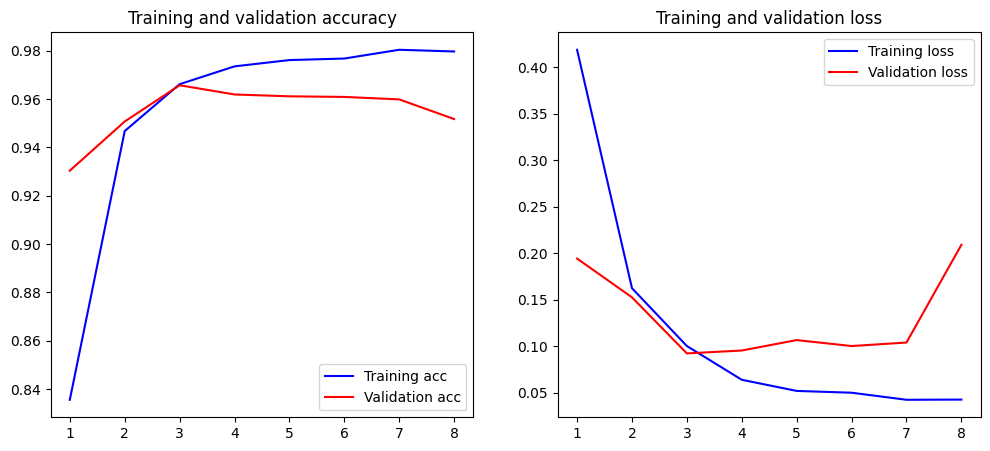

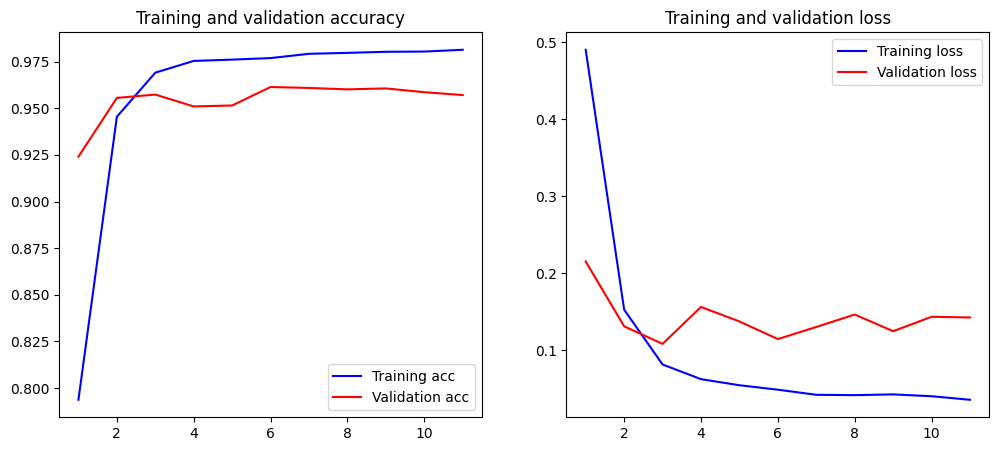

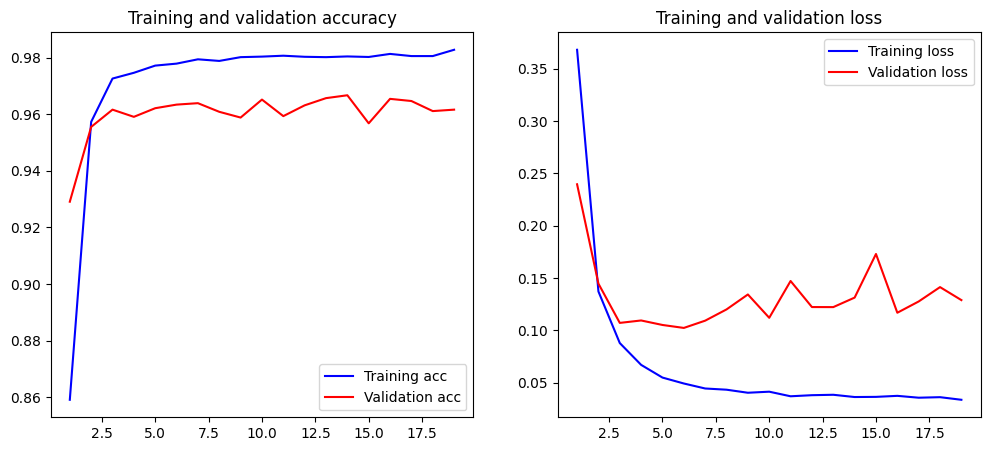

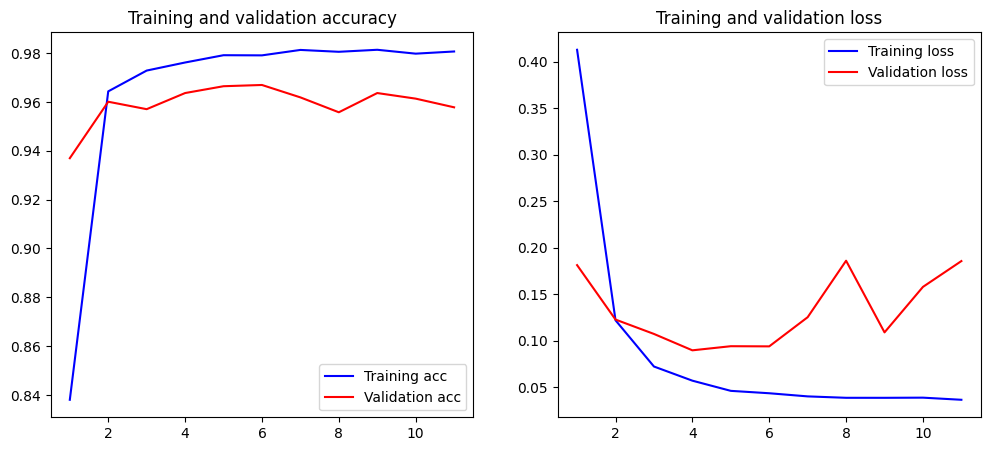

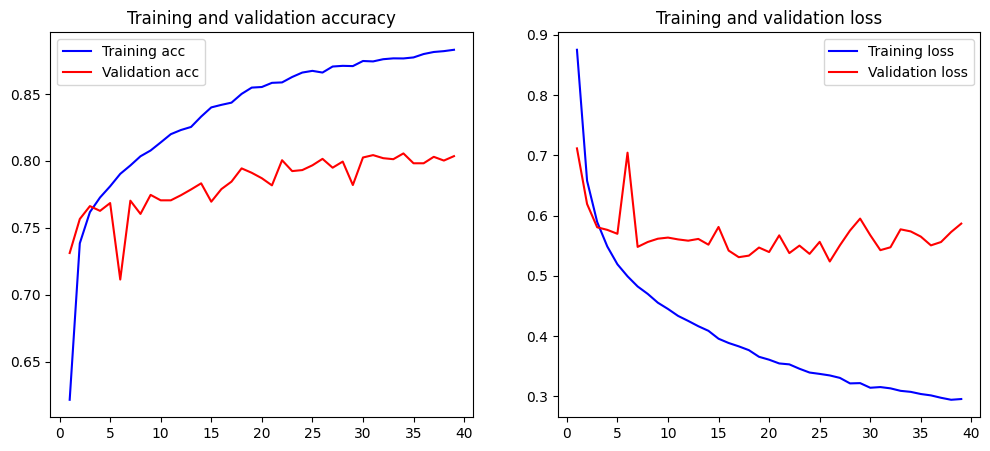

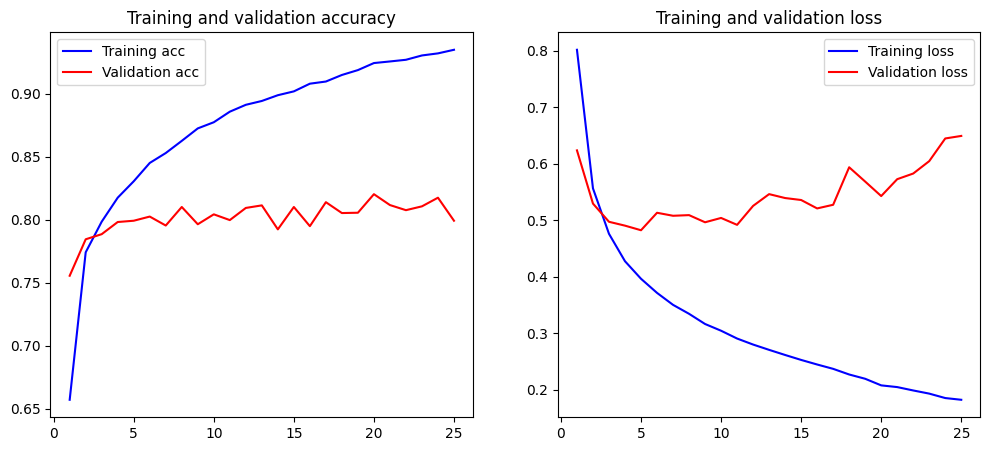

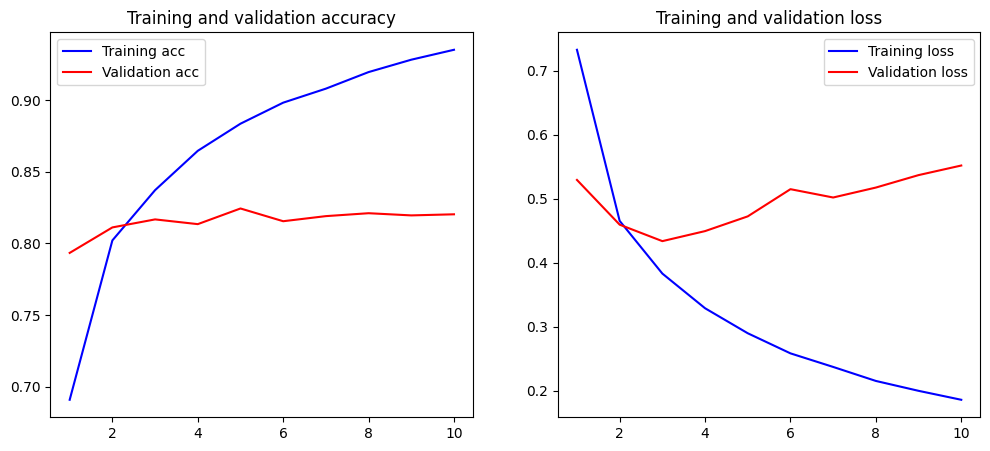

In [6]:
models_run = ["20", "50", "150", "200", "250", "gensim_glove-twitter-25",
              "gensim_glove-twitter-50", "gensim_glove-twitter-100"]
for m in models_run:
    run_model(m, f"_{maxlen}_words", folder="entrega")


In [7]:
%tensorboard


UsageError: Line magic function `%tensorboard` not found.


In [5]:
architectures = ["flatten", "pooling", "conv"]
for embed in ["50", "gensim_glove-twitter-50"]:
    for typemodel in architectures:
        model, _ = create_model(embed, typemodel)
        filename = f"./figuras/model_{embed}_{typemodel}.png"
        try:
            keras.utils.plot_model(model, filename, True, True,
                                   show_layer_activations=True, show_trainable=True)
        except:
            pass


2023-10-26 22:31:30.730999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 22:31:30.762996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 22:31:30.763044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 22:31:30.764441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 22:31:30.764479: I tensorflow/compile